In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [3]:
# define problem
problem = GMM(negate=True).to(**tkwargs)

In [4]:
problem.ref_point = torch.tensor([0., 0.], **tkwargs)

In [5]:
def plot_objective(problem, num_samples: int = 200):
    num_dim = problem.bounds.shape[-1]
    num_obj = problem.ref_point.shape[-1]

    fig = plt.figure(figsize=(5 * (num_dim + 1), 5))

    # only plot the first two dimensions
    xx, yy = np.meshgrid(
        np.linspace(
            *problem.bounds.cpu().t()[0], num_samples
        ),
        np.linspace(
            *problem.bounds.cpu().t()[1], num_samples
        ),
    )
    input_data = np.vstack((xx.flatten(), yy.flatten())).T
    input_data = torch.from_numpy(input_data)
    z = problem(input_data.to(**tkwargs)).cpu()
    pareto = is_non_dominated(z).cpu()
    pareto_set = z.cpu().numpy().copy()
    pareto_set[~pareto] = np.nan

    for i in range(num_dim):
        ax = plt.subplot2grid((1, num_dim + 1), (0, i))
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')

        # plot functions
        countourset = ax.contourf(
            xx,
            yy,
            z[:, i].reshape(xx.shape),
        )

        # plot pareto set mask
        ax.scatter(*input_data[pareto].t(), color='tab:red', s=10, label='pareto set')

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"objective {i+1}")
        ax.legend()
        clb.ax.set_title('z')

    ax_pareto = plt.subplot2grid((1, num_dim + 1), (0, num_dim))
    idx = np.argsort(pareto_set[:, 0])
    ax_pareto.plot(*pareto_set[idx].T, color='tab:red', label='approximated pareto front')
    ax_pareto.scatter(*pareto_set[idx].T, color='tab:red', s=10)
    ax_pareto.scatter(*problem.ref_point.cpu().t(), color='tab:red', marker='x', label='refence point')
    ax_pareto.set_title("pareto front")
    ax_pareto.legend()
    plt.tight_layout()

## Problem

The approximated pareto set and pareto front is shown in the following figure.

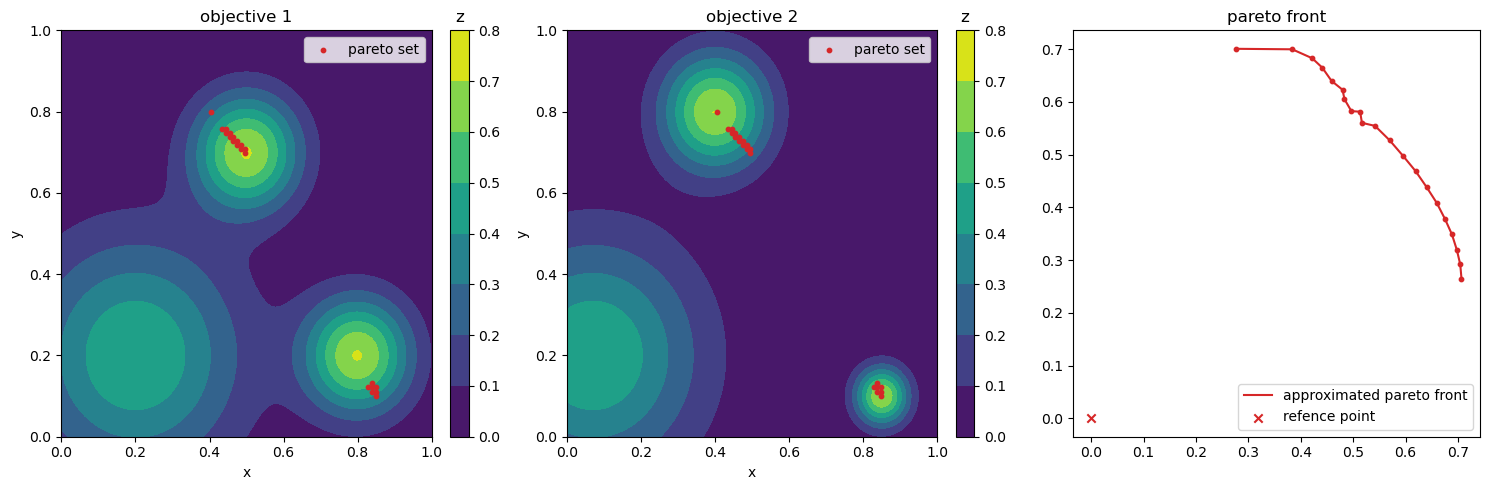

In [6]:
plot_objective(problem, num_samples=100)

In [7]:
def generate_initial_data(problem, n=50):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

# def generate_initial_data(problem, n=6):
#     X_obs = torch.empty(0, problem.bounds.shape[-1])
#     y_obs = torch.empty(0, problem.bounds.shape[-1])
#     while len(X_obs) < n:
#         x = draw_sobol_samples(bounds=problem.bounds, n=1, q=1).squeeze(1)
#         y = problem(x)
#         if (y > problem.ref_point).all(dim=-1).item():
#             X_obs = torch.concat([X_obs, x], dim=0)
#             y_obs = torch.concat([y_obs, y], dim=0)

#     return X_obs, y_obs

In [8]:
init_x, init_y = generate_initial_data(problem, n=50)

## Pareto dominance

**For Maximization**: an objective vector $\mathbf f(\mathbf x)$ Pareto-dominates $\mathbf f (\mathbf x′)$, denoted as $\mathbf f(\mathbf x) \succ \mathbf f(\mathbf x')$, if $f^{(m)}(x) \geq f^{(m)}(x′)$ for all $m = 1, \dots, M$ and there exists at least one $m \in \{1, . . . , M\}$ such that $f^{(m)}(x) > f^{(m)}(x′)$.

## Modeling the objective space

A classifier answers a question that whether the objective value $y$ outperform a certain fraction of point: $\hat \pi(\mathbf x) = p(y \geq \tau \mid \mathbf x)$.

We try to model the separately model the objectives via BORE (PI). For a bi-objective case we have: $$\hat \pi^1 (\mathbf x) = p(y^1 \geq \tau^1 \mid \mathbf x)$$ $$ \hat \pi^2 (\mathbf x) = p(y^2 \geq \tau^2 \mid \mathbf x)\,.$$
Assuming the objectives are independent: $$ p(y^1 \geq \tau^1, y^2 \geq \tau^2 \mid \mathbf x) = p(y^1 \geq \tau^1 \mid \mathbf x) \cdot p(y^1 \geq \tau^1 \mid \mathbf x)\,. $$
In this case, this convert to determine whether $\mathbf f(\mathbf x)$ weakly dominate a point $(\tau^1, \tau^2)$: $p(\mathbf f(\mathbf x) \succeq \bm \tau)$.

If we jointly model **BORE** with $\gamma$, we can dynamically vary the threshold $(\tau^m)^M_{m=1}$, which allowing us:
- Output the likelihood for different $\bm \tau$
- We can map the current observation to $\bm \tau$: $\bm \tau = \mathbf f(\mathbf x_i)$, and output likelihood that a given $\mathbf x$ outperforming an specific observation $\mathbf x_i$.

## Generate data

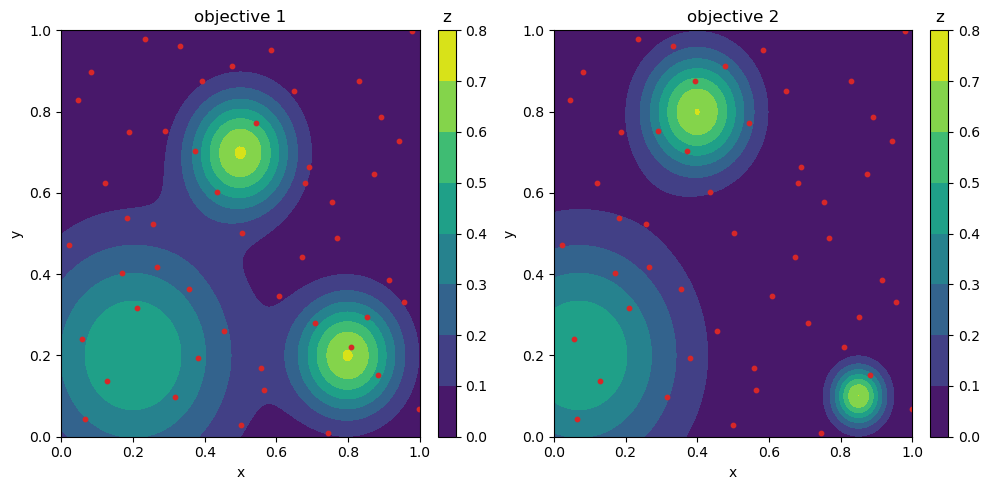

In [9]:
num_dim = problem.bounds.shape[-1]
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.cpu().t()[0], 200
    ),
    np.linspace(
        *problem.bounds.cpu().t()[1], 200
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
input_data = torch.from_numpy(input_data).to(**tkwargs)
z = problem(input_data.to(**tkwargs))

fig = plt.figure(figsize=(5 * (num_dim), 5))
for i in range(num_dim):
    ax = plt.subplot2grid((1, num_dim), (0, i))
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        z[:, i].cpu().reshape(xx.shape),
    )

    # plot observations
    ax.scatter(*init_x.cpu().t(), s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"objective {i+1}")
    clb.ax.set_title('z')
plt.tight_layout()

In [10]:
from optimizers.lfbo.molfbo import MOLFBO
x_obs = init_x
y_obs = init_y

molfbo = MOLFBO(problem, **tkwargs)

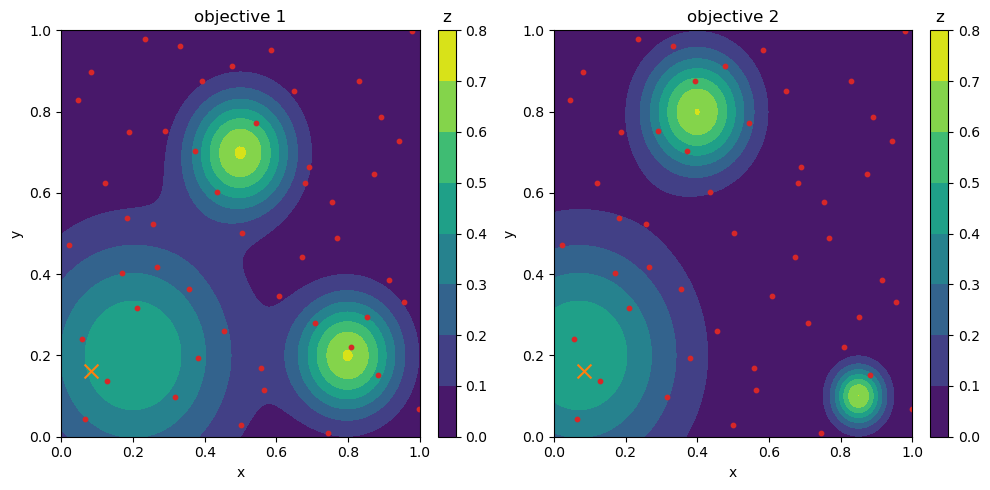

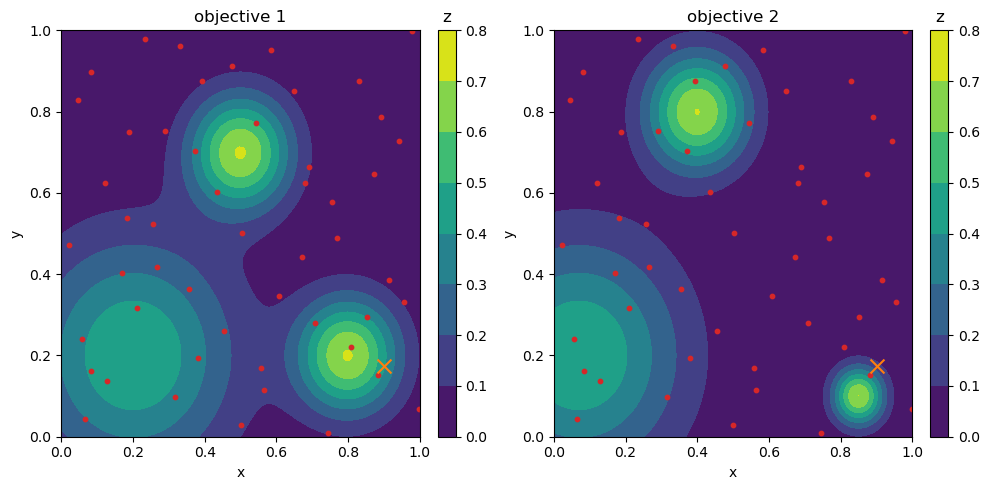

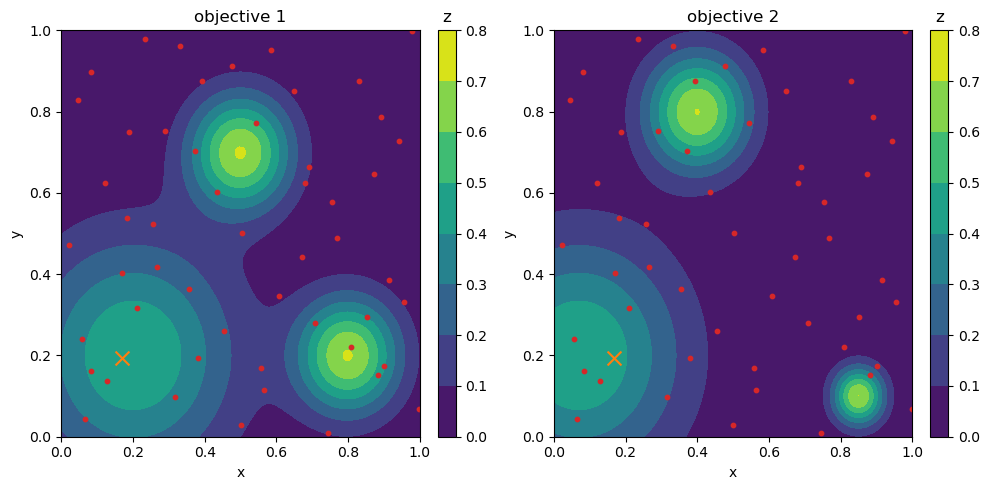

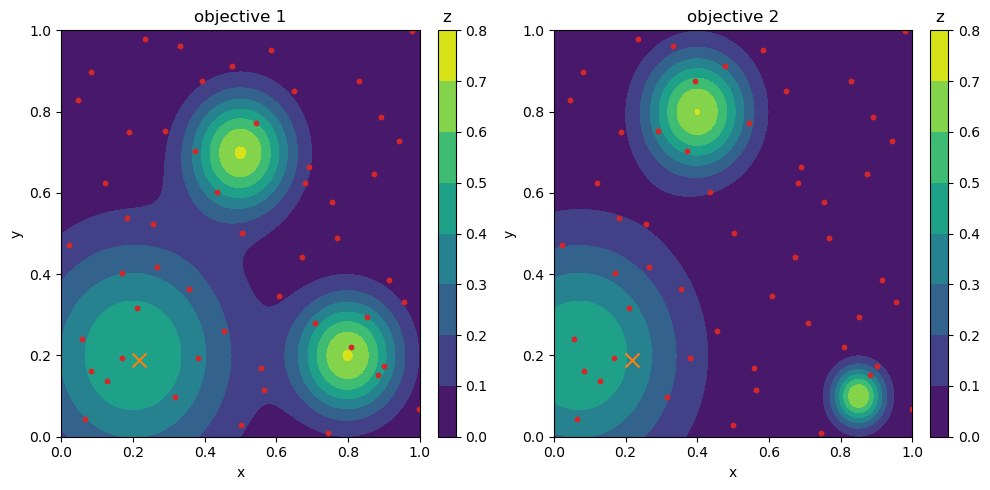

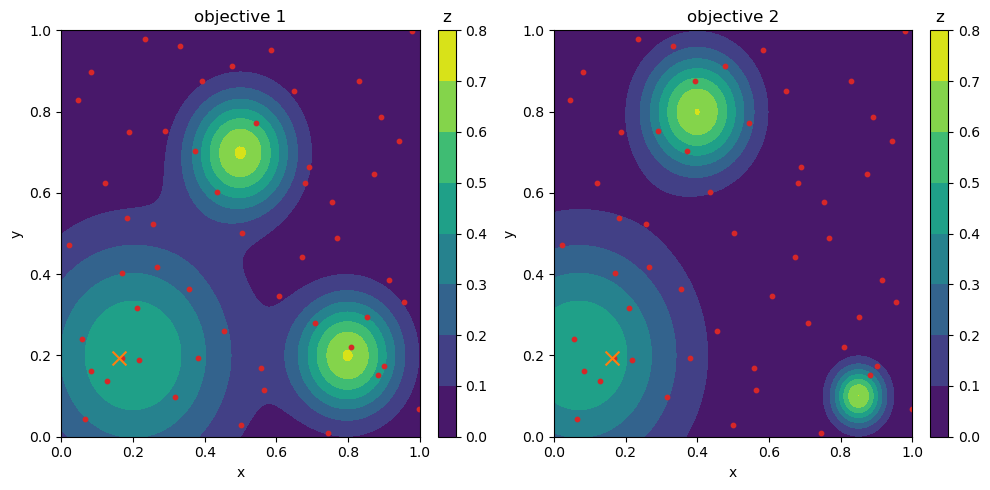

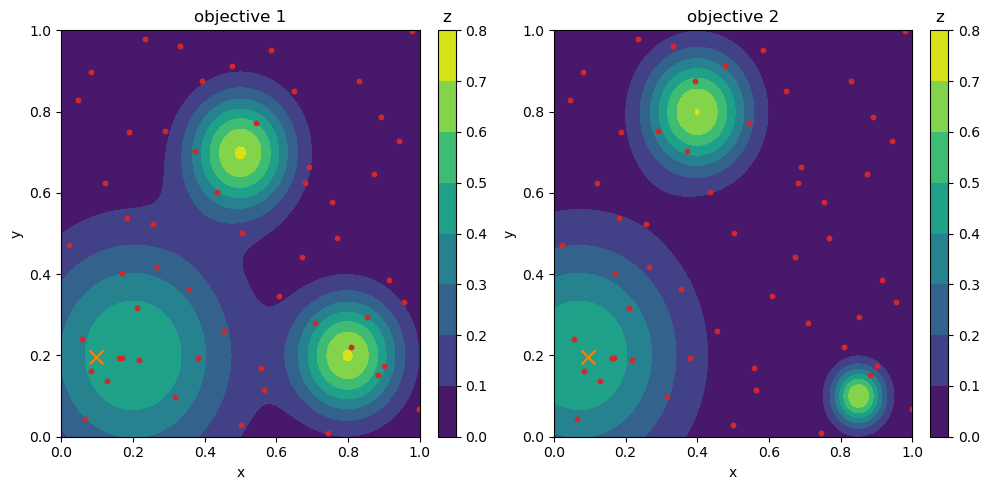

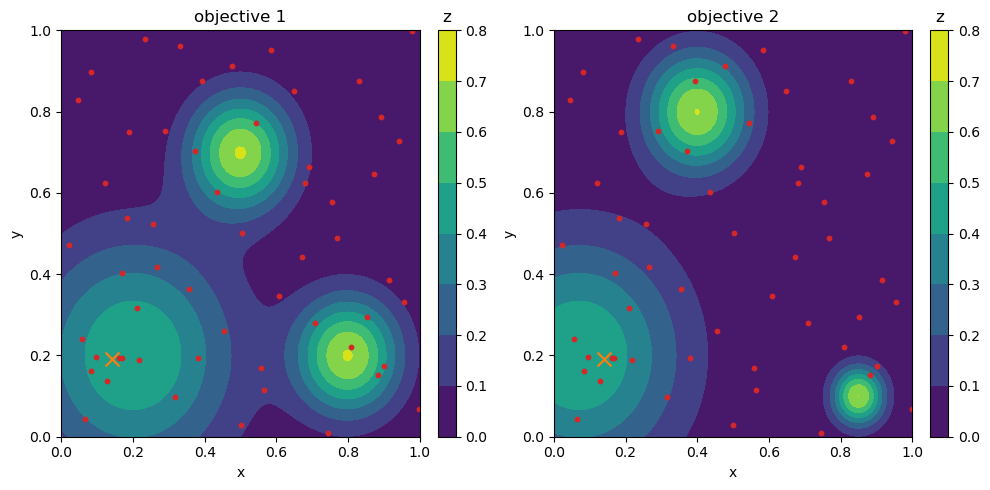

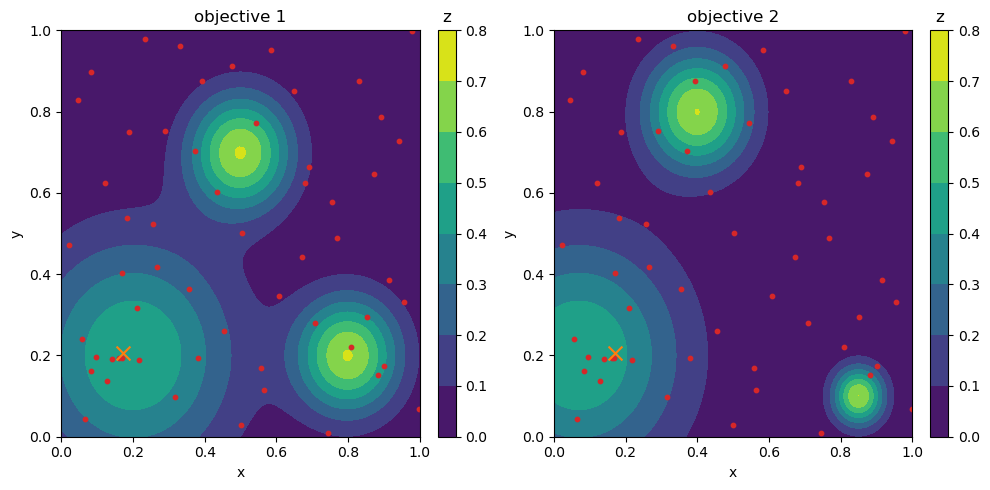

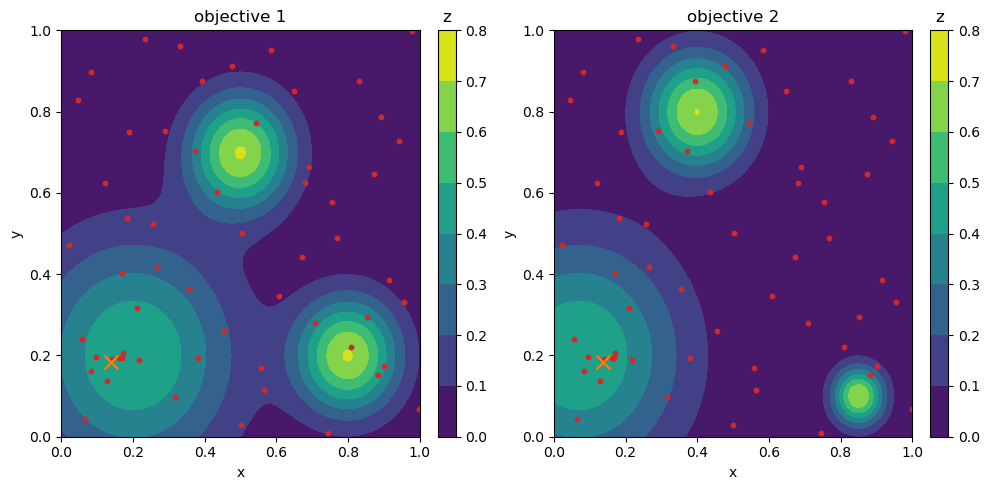

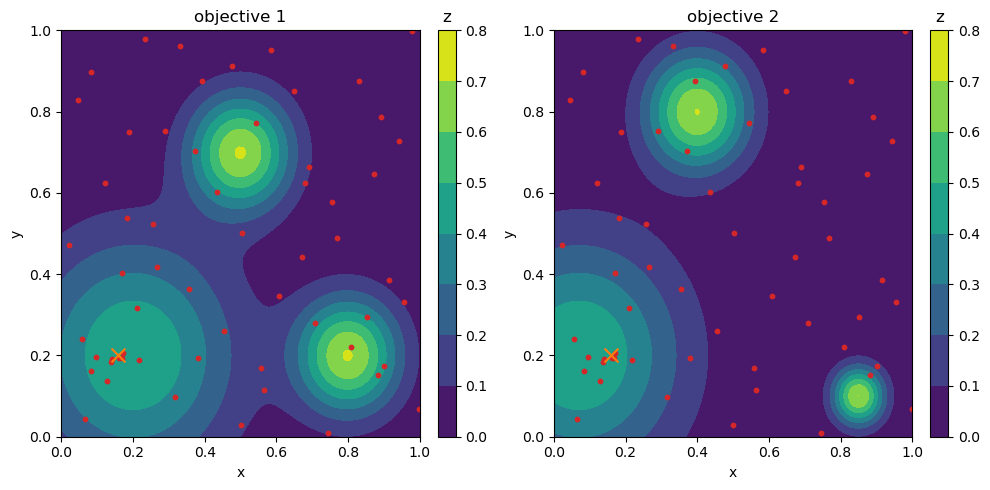

In [11]:
for _ in range(10):
    new_x = molfbo.observe_and_suggest(x_obs, y_obs)
    new_y = problem(new_x)
    
    fig = plt.figure(figsize=(5 * (num_dim), 5))
    for i in range(num_dim):
        ax = plt.subplot2grid((1, num_dim), (0, i))
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')
    
        # plot functions
        countourset = ax.contourf(
            xx,
            yy,
            z[:, i].cpu().reshape(xx.shape),
        )
    
        # plot observations
        ax.scatter(*x_obs.cpu().t(), s=10, color='tab:red')
        ax.scatter(*new_x.cpu().t(), s=100, marker='x', color='tab:orange')
    
        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"objective {i+1}")
        clb.ax.set_title('z')
    plt.tight_layout()
    plt.show()
    
    x_obs = torch.concat([x_obs, new_x])
    y_obs = torch.concat([y_obs, new_y])

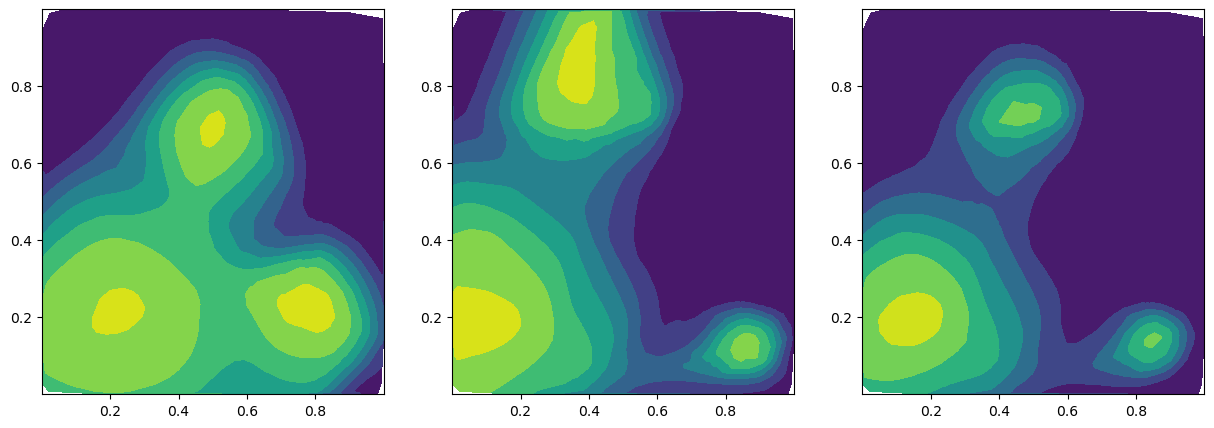

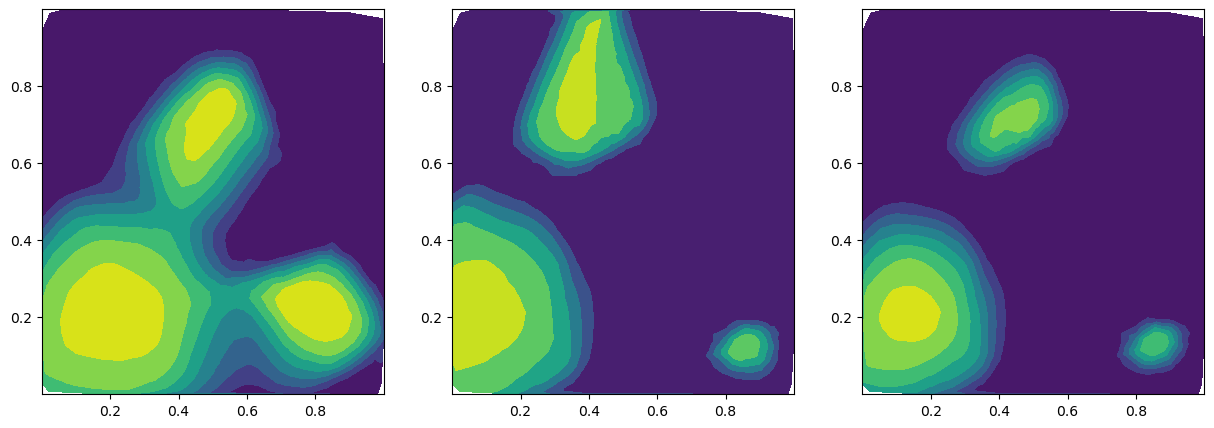

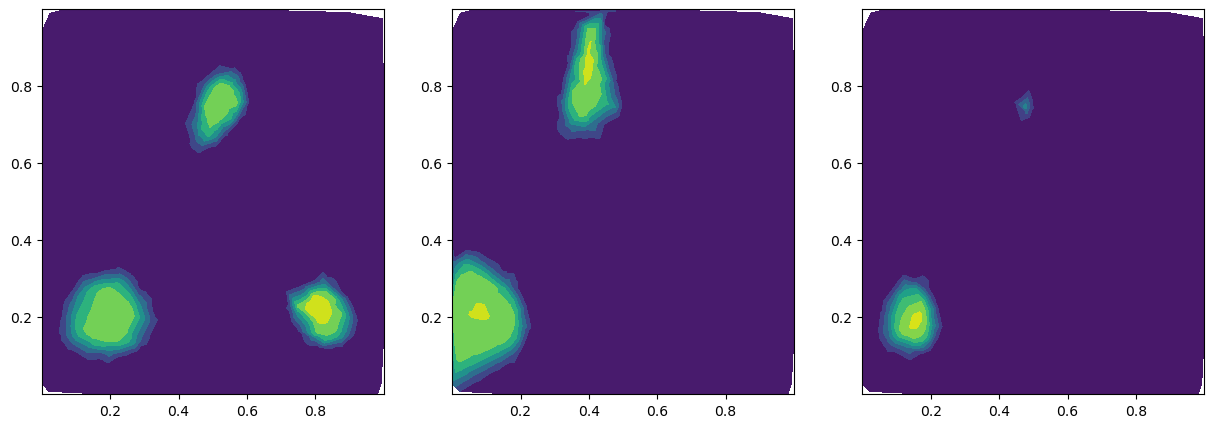

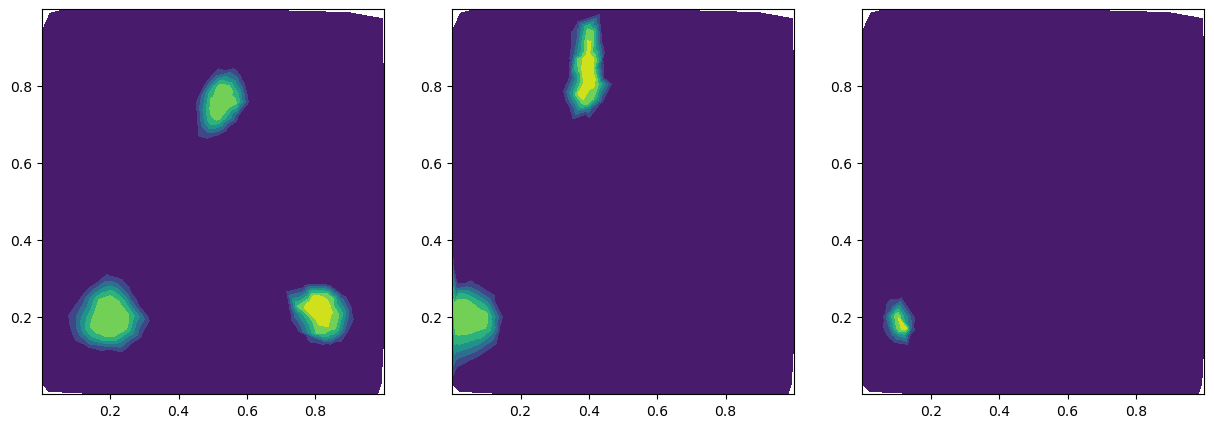

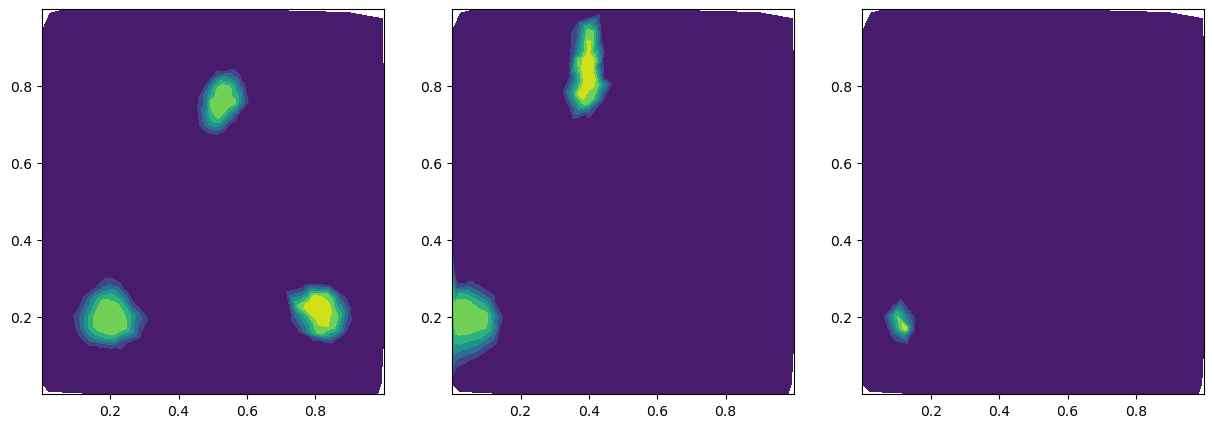

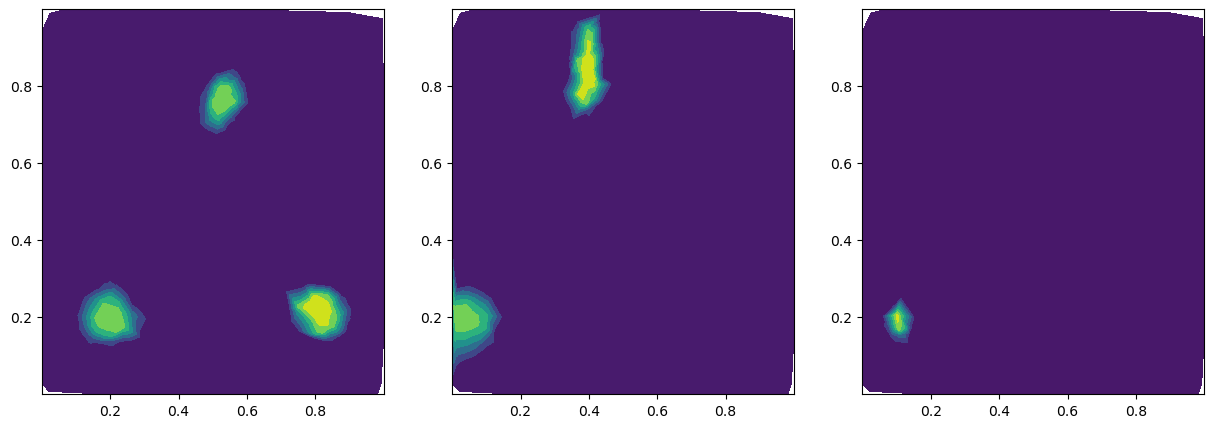

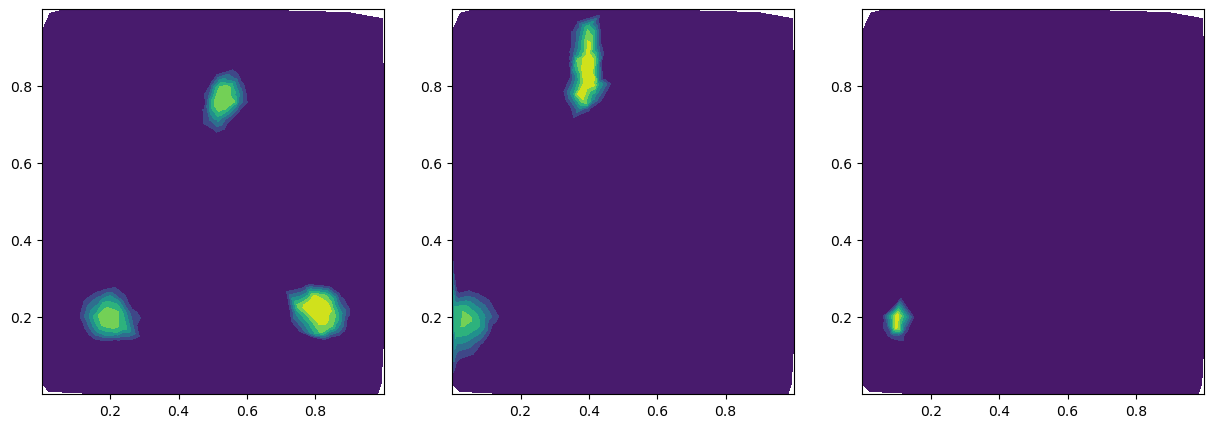

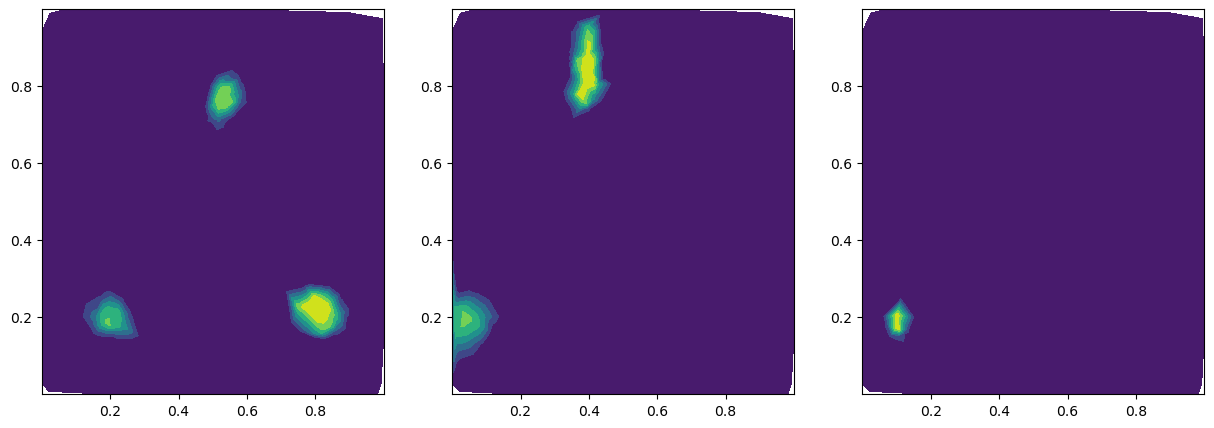

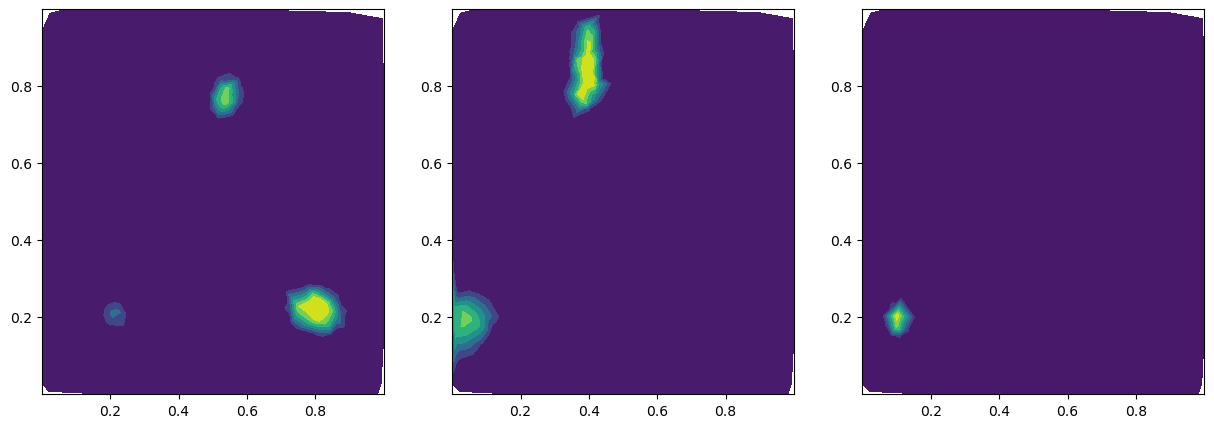

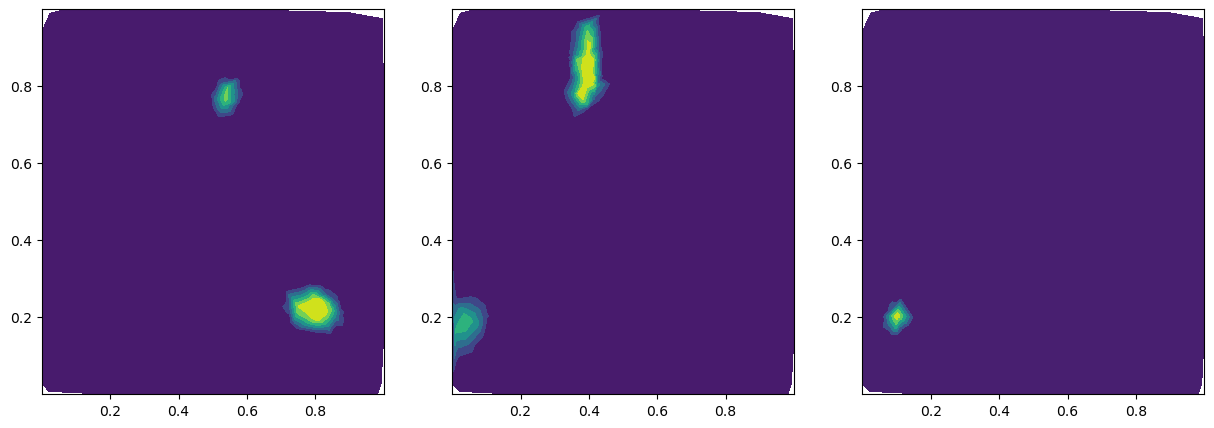

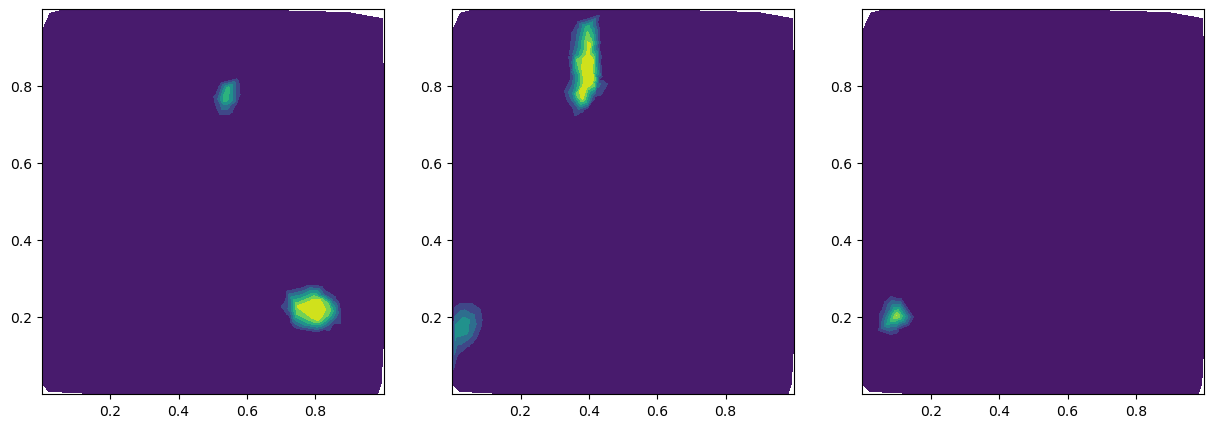

In [12]:
from botorch.utils.transforms import unnormalize, normalize

bd = FastNondominatedPartitioning(ref_point=molfbo.problem.ref_point, Y=y_obs)
u, _ = bd.hypercell_bounds

x_cands = draw_sobol_samples(bounds=molfbo.standard_bounds, n=1, q=molfbo.n_candidates).squeeze(0)
for ref in u:
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    preds = torch.empty((0, x_cands.shape[0]), **molfbo.tkwargs)
    for i, clf in enumerate(molfbo.clf_list):
        gamma = ((y_obs[:, i:i+1] >= ref[0]).sum() / len(y_obs)).to(**molfbo.tkwargs)

        with torch.no_grad():
            preds = torch.concat([preds, clf.predict(x_cands, gamma=gamma).unsqueeze(0)], dim=0)

        axes[i].tricontourf(
            unnormalize(x_cands, problem.bounds)[:, 0].cpu(),
            unnormalize(x_cands, problem.bounds)[:, 1].cpu(),
            preds[-1].cpu(),
        )
        # plt.show()

    agg_preds = torch.cumprod(preds, dim=0)[-1]
    axes[2].tricontourf(
        unnormalize(x_cands, problem.bounds)[:, 0].cpu(),
        unnormalize(x_cands, problem.bounds)[:, 1].cpu(),
        agg_preds.cpu(),
    )
    plt.show()